In [1]:
#install necessary libraries and dependencies
!pip install tensorflow opencv-python matplotlib

     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ---------------------------------------- 48.7/48.7 kB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/385.2 MB ? eta -:--:--
   ---------------------------------------- 1.9/385.2 MB 40.7 MB/s eta 0:00:10
    --------------------------------------- 4.9/385.2 MB 62.5 MB/s eta 0:00:07
    --------------------------------------- 6.9/385.2 MB 55.5 MB/s eta 0:00:07
   - -------------------------------------- 10.1/385.2 MB 64.3 MB/s eta 0:00:06
   - -------------------------------------- 13.2/385.2 MB 73.1 MB/s eta 0:00:06
   - -------------------------------------- 15.2/385.2 MB 65.6 MB/s eta 0:00:06
   - -------------------------------------- 18.9/385.2 MB 72.6 MB/s eta 0:00:06
   -- ------------------------------------- 21.8/385.2 MB 73.1 MB/s eta 0:00:05
   -- ------------------------------------- 24.1/385.2 MB 81.8 MB/s eta 0:00:05
   -- ------------------------------------- 26.3/385.2 MB 72

In [15]:
import tensorflow as tf 
import os #operating system interaction
import cv2 #for realtime computer vision
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load dataset
def load_dataset(base_dir, target_size=(224, 224)):
    images = []
    labels = []
    label_map = {'infected': 1, 'notinfected': 0}  # Define label mapping
   
    # Iterate through each subdirectory (each representing a class label)
    for label in label_map.keys():
        class_dir = os.path.join(base_dir, label)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
                    img_path = os.path.join(class_dir, filename)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, target_size)  # Resize to target size (224x224)
                        images.append(img)
                        labels.append(label_map[label])
   
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
   
    return images, labels, label_map

# Load datasets
base_dir = 'data'
images, labels, label_map = load_dataset(base_dir)

test1_dir = 'Test1'
test1_images, test1_labels, test1_label_map = load_dataset(test1_dir)

test2_dir = 'Test2'
test2_images, test2_labels, test2_label_map = load_dataset(test2_dir)

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Verify the splits
print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')
print(f'Test1 set size: {len(test1_images)}')
print(f'Test2 set size: {len(test2_images)}')


Training set size: 1152
Validation set size: 384
Test set size: 384
Test1 set size: 398
Test2 set size: 1588


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input

# function to preprocess dataset
def preprocess_images(images):
    preprocessed_images = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    for img in images:
        #ensure image is grayscale
        if len(img.shape) == 3 and img.shape[2] == 3: #if it's a color image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Apply CLAHE to adjust contrast
        img_clahe = clahe.apply(img)
        img_resized = cv2.resize(img_clahe, (224, 224))
        
        #convert to 3 channels by duplicating the grayscale values
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)
        
        # Normalize pixel values using preprocess_input
        #img_normalized = img_clahe / 255.0
        img_preprocessed = preprocess_input(img_resized)
        preprocessed_images.append(img_preprocessed)
    return np.array(preprocessed_images)

X_train = preprocess_images(X_train)
X_val = preprocess_images(X_val)
X_test = preprocess_images(X_test)

# Data augmentation setup using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#fit the genarator to the training data
datagen.fit(X_train)

#genarate augmented data for training
train_gen = datagen.flow(X_train, y_train, batch_size=32)


# Verify preprocessed images
print(f'Preprocessed training set shape: {X_train.shape}')
print(f'Preprocessed validation set shape: {X_val.shape}')
print(f'Preprocessed test set shape: {X_test.shape}')


Preprocessed training set shape: (1152, 224, 224, 3)
Preprocessed validation set shape: (384, 224, 224, 3)
Preprocessed test set shape: (384, 224, 224, 3)


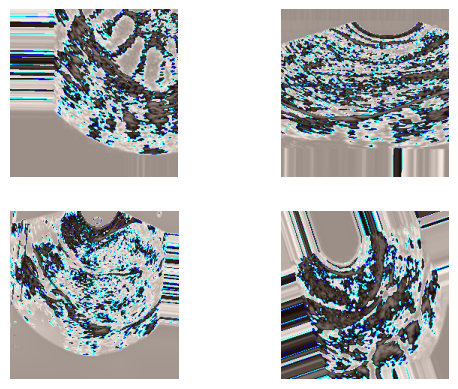

In [6]:
# Visualize augmented images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=4):
    for i in range(0, 4):
        plt.subplot(2, 2, i + 1)
        plt.imshow(X_batch[i].astype('uint8'))
        plt.axis('off')
    plt.show()
    break

In [21]:
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

#load VGG16 model and set trainable to False, this is to preserve the learned features from the pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
    
#extract features using VGG16
def extract_features(model, data):
    features = model.predict(data)
    features = features.reshape(features.shape[0], -1) #flatten the features
    return features

X_train_features = extract_features(base_model, X_train)
X_val_features = extract_features(base_model, X_val)
X_test_features = extract_features(base_model, X_test)

#hyperparameter optimisation
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_features, y_train)

best_rf_classifier = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_rf_classifier.predict(X_test_features)
test_acc = accuracy_score(y_test, y_pred)
print(f'Test accuracy after hyperparameter tuning: {test_acc}')

36/36 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step
Fitting 3 folds for each of 216 candidates, totalling 648 fits
Test accuracy after hyperparameter tuning: 1.0


In [23]:
# Retrieve the best parameters and the best model
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_rf_classifier = grid_search.best_estimator_

print(f'Best parameters found: {best_params}')
print(f'Best cross-validation score: {best_score}')

# Use the best_rf_classifier for predictions
y_pred = best_rf_classifier.predict(X_test_features)
#train a random forest classifier
#rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
#rf_classifier.fit(X_train_features, y_train)

#evaluate the RF Classifier
#y_pred = rf_classifier.predict(X_test_features)
#test_acc = accuracy_score(y_test, y_pred)
#print(f'Test accuracy before hyperparameter tuning: {test_acc}')

Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 1.0


In [25]:
# Extract features for Test1 and Test2
test1_features = extract_features(base_model, test1_images)
test2_features = extract_features(base_model, test2_images)

# Evaluate the trained model on Test1 and Test2
y_test1_pred = best_rf_classifier.predict(test1_features)
test1_acc = accuracy_score(test1_labels, y_test1_pred)
print(f'Test1 accuracy: {test1_acc}')

y_test2_pred = best_rf_classifier.predict(test2_features)
test2_acc = accuracy_score(test2_labels, y_test2_pred)
print(f'Test2 accuracy: {test2_acc}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step
Test1 accuracy: 0.9974874371859297
Test2 accuracy: 0.9955919395465995


Train accuracy: 1.0
Test1 Accuracy: 0.9974874371859297
Test1 Confusion Matrix:
[[229   0]
 [  1 168]]
Test1 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       229
           1       1.00      0.99      1.00       169

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398

Test2 Accuracy: 0.9955919395465995
Test2 Confusion Matrix:
[[906   7]
 [  0 675]]
Test2 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       913
           1       0.99      1.00      0.99       675

    accuracy                           1.00      1588
   macro avg       0.99      1.00      1.00      1588
weighted avg       1.00      1.00      1.00      1588



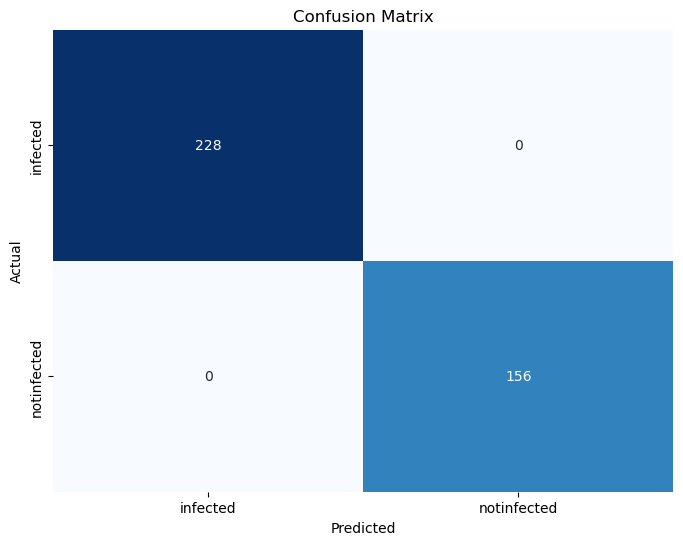

In [29]:
#predict on training set
y_train_pred = best_rf_classifier.predict(X_train_features)

#calculate training accuracy
train_acc = accuracy_score(y_train, y_train_pred)
print (f'Train accuracy: {train_acc}')

#accuracy metrics using confusioon matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to evaluate the model
def evaluate_model(model, features, labels, dataset_name):
    # Generate predictions
    predictions = model.predict(features)
    
    accuracy = accuracy_score(labels, predictions)
    cm = confusion_matrix(labels, predictions)
    report = classification_report(labels, predictions)
    
    print(f'{dataset_name} Accuracy: {accuracy}')
    print(f'{dataset_name} Confusion Matrix:\n{cm}')
    print(f'{dataset_name} Classification Report:\n{report}')

# Evaluate on Test1 and Test2
evaluate_model(best_rf_classifier, test1_features, test1_labels, 'Test1')
evaluate_model(best_rf_classifier, test2_features, test2_labels, 'Test2')

#generate confusion matrix for training set
cm = confusion_matrix(y_test, y_pred)

#plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['notinfected', 'infected']))

              precision    recall  f1-score   support

 notinfected       1.00      1.00      1.00       228
    infected       1.00      1.00      1.00       156

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



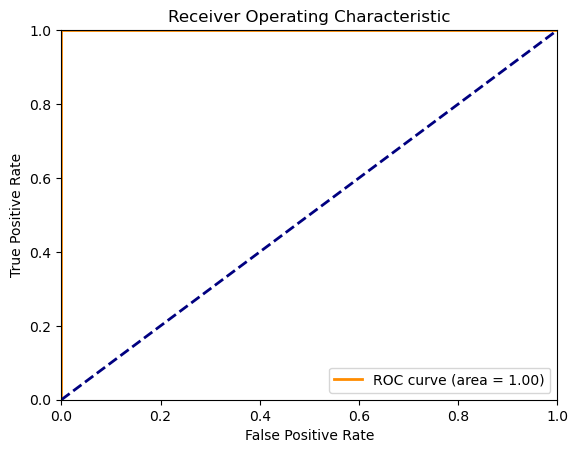

In [37]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = best_rf_classifier.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


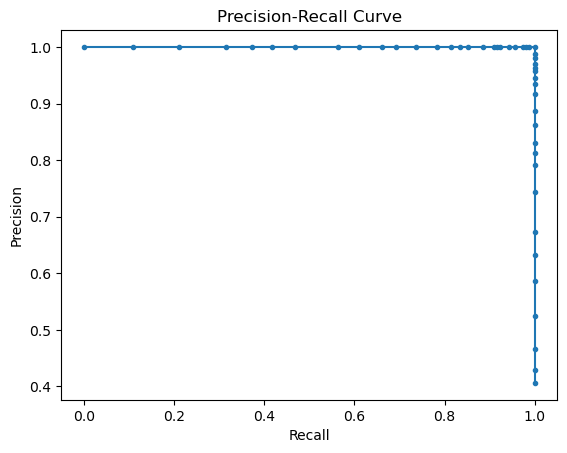

In [39]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [43]:
from sklearn.metrics import log_loss

loss = log_loss(y_test, y_prob)
print(f'Log Loss: {loss}')


Log Loss: 0.06194328629191587


In [11]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test, y_pred)
print(f'Matthews Correlation Coefficient: {mcc}')


Matthews Correlation Coefficient: 1.0


In [12]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_test, y_pred)
print(f'Cohen\'s Kappa: {kappa}')


Cohen's Kappa: 1.0


In [13]:
from sklearn.metrics import balanced_accuracy_score

bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy: {bal_acc}')


Balanced Accuracy: 1.0


In [14]:
from sklearn.metrics import recall_score

specificity = recall_score(y_test, y_pred, pos_label=0)
print(f'Specificity: {specificity}')


Specificity: 1.0


In [15]:
from sklearn.metrics import fbeta_score

f2_score = fbeta_score(y_test, y_pred, beta=2)
print(f'F2 Score: {f2_score}')


F2 Score: 1.0


In [18]:
# Predict on the validation/test set
y_val_pred = rf_classifier.predict(X_val_features)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')


Validation Accuracy: 1.0000


In [19]:
# Classification report for training set
print("Training Set Classification Report")
print(classification_report(y_train, y_train_pred, target_names=['Not Infected', 'Infected']))

# Classification report for validation/test set
print("Validation Set Classification Report")
print(classification_report(y_val, y_val_pred, target_names=['Not Infected', 'Infected']))


Training Set Classification Report
              precision    recall  f1-score   support

Not Infected       1.00      1.00      1.00       683
    Infected       1.00      1.00      1.00       468

    accuracy                           1.00      1151
   macro avg       1.00      1.00      1.00      1151
weighted avg       1.00      1.00      1.00      1151

Validation Set Classification Report
              precision    recall  f1-score   support

Not Infected       1.00      1.00      1.00       227
    Infected       1.00      1.00      1.00       157

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



In [20]:
# Predict probabilities for log loss calculation
y_train_proba = rf_classifier.predict_proba(X_train_features)
y_val_proba = rf_classifier.predict_proba(X_val_features)

# Log Loss for training set
train_log_loss = log_loss(y_train, y_train_proba)
print(f'Training Log Loss: {train_log_loss:.4f}')

# Log Loss for validation/test set
val_log_loss = log_loss(y_val, y_val_proba)
print(f'Validation Log Loss: {val_log_loss:.4f}')


Training Log Loss: 0.0202
Validation Log Loss: 0.0611


In [45]:
import joblib

# Save the Random Forest model
joblib.dump(best_rf_classifier, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [7]:
# Save the VGG16 model
base_model.save('vgg16_feature_extractor.h5')

In [8]:
from tensorflow.keras.models import load_model

# Load the VGG16 model (feature extractor)
base_model = load_model('vgg16_feature_extractor.h5')

In [9]:
import joblib

# Load the Random Forest model
rf_classifier = joblib.load('random_forest_model.joblib')

In [10]:
import cv2
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_single_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found or cannot be loaded.")
    return img

def preprocess_image(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    
    # Convert to grayscale if the image has 3 channels (BGR)
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply CLAHE
    img_clahe = clahe.apply(image)
    
    # Resize to 224x224
    img_resized = cv2.resize(img_clahe, (224, 224))
    
    # Convert back to 3 channels by duplicating the grayscale values
    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)
    
    # Normalize using VGG16 preprocess_input
    img_preprocessed = preprocess_input(img_resized)
    
    return np.expand_dims(img_preprocessed, axis=0)  # Expand dimensions for model input

# Load and preprocess the image
image_path = 'data/nopcos3.jpg'
image = load_single_image(image_path)
test_image = preprocess_image(image)

# Now, `test_image` is ready for prediction


In [11]:
# Predict using the VGG16 model as a feature extractor
features = base_model.predict(test_image)
features = features.reshape(features.shape[0], -1)

# Predict with the Random Forest classifier
prediction = rf_classifier.predict(features)

# Output the result (assuming 1 for infected, 0 for notinfected)
label_map = {1: 'infected', 0: 'notinfected'}
print(f'Prediction: {label_map[prediction[0]]}')

1/1 [==============================] - 0s 201ms/step
Prediction: notinfected


In [12]:
import sklearn
print(sklearn.__version__)


1.2.1
